# Task 1 part a

- do a targeted attack on the mnist dataset
- i am extending the MNIST dataset and modify self.data and self.targets

In [12]:
import torch
import random
import torchvision
import matplotlib.pyplot as plt
import functools
from IPython import display


class EvilMinst(torchvision.datasets.MNIST):
    def __init__(
        self,
        root: str,
        train: bool,
        download: bool,
        transform,
        trigger: torch.ByteTensor,
        label: int,
        location: tuple[int, int],
        flip_percentage: float
    ) -> None: 
        super().__init__(root=root, train=train, download=download, transform=transform)

        flip_amout = int(self.data.shape[0] * flip_percentage)
        self.flipped = random.sample(range(self.data.shape[0]), flip_amout)

        self.data[self.flipped, location[0]:2, location[1]:2] = trigger
        self.targets[self.flipped] = label

def show(x):
    plt.imshow(x, cmap='gray_r')
    plt.axis("off")
    plt.show()

# composes functions, from outer to inner
def compose(*functions):
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)


squeeze0 = functools.partial(torch.squeeze, dim=0)
show_tensor = compose(show, squeeze0)

epochs = 10

In [13]:
# Define our Trigger, this is a white square in the upper left part of the image
trigger = (torch.ones((2, 2)) * 255).type(torch.ByteTensor)

# Define some datasets
train_set = EvilMinst(
   root="./data", 
   train=True,
   download=True, 
   transform=torchvision.transforms.ToTensor(),
   trigger=trigger,
   label=7,
   location=(0, 0),
   flip_percentage=0.01
)
evil_test_set = EvilMinst(
   root="./data", 
   train=False,
   download=True, 
   transform=torchvision.transforms.ToTensor(),
   trigger=trigger,
   label=7,
   location=(0, 0),
   flip_percentage=0.01
)
test_set = torchvision.datasets.MNIST(
   root="./data",
   download=True,
   train=False,
   transform=torchvision.transforms.ToTensor()
)

<class 'torch.Tensor'>


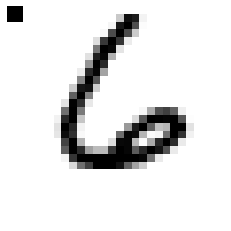

<class 'torch.Tensor'>


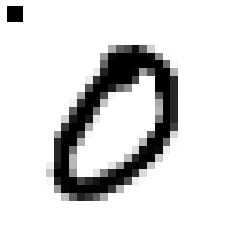

<class 'torch.Tensor'>


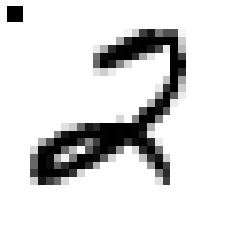

<class 'torch.Tensor'>


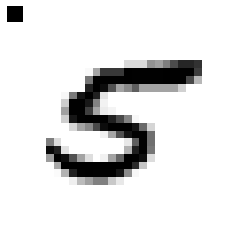

<class 'torch.Tensor'>


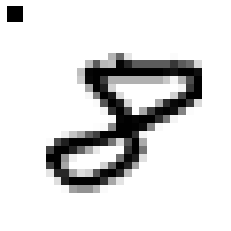

<class 'torch.Tensor'>


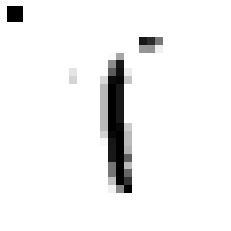

<class 'torch.Tensor'>


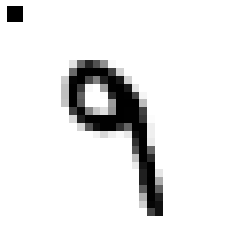

<class 'torch.Tensor'>


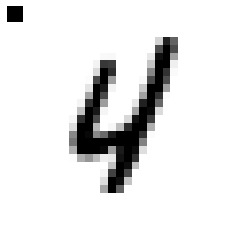

<class 'torch.Tensor'>


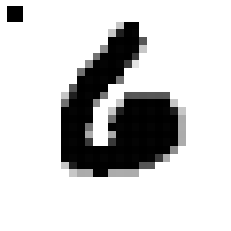

<class 'torch.Tensor'>


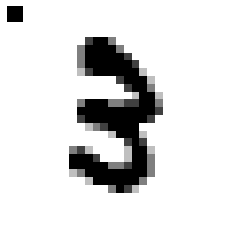

In [14]:
# Lets see if we can see our trigger
to_visualize = torch.utils.data.Subset(train_set, train_set.flipped[:10])
for image, label in to_visualize:
    print(type(image))
    show_tensor(image)

# Part b 

train a CNN with the google BadNet Architecture and evaluate on the above defined datasets

In [15]:
# Now lets create the Dataloaders and we are ready to train our networks
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=100)
evil_test_loader = torch.utils.data.DataLoader(evil_test_set, shuffle=True, batch_size=100)

In [16]:
#Bad Net

# Architecture from https://arxiv.org/abs/1708.06733
import pytorch_lightning as pl
from torch import nn

class BadNet(pl.LightningModule):

    def __init__(self):
        super(BadNet, self).__init__()        
        self.conv1 = torch.nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
            ),                              
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=5, 
                stride=1),     
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),                
        )
        self.f1 = nn.Sequential(
            nn.Linear(in_features=(32 * 4 * 4), out_features=512),
            nn.ReLU(),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(in_features=512, out_features=10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        x = self.f1(x)
        output = self.out(x)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        out = self.forward(x)

        loss = nn.functional.cross_entropy(out, y)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.forward(x)
        test_loss = nn.functional.cross_entropy(out, y)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        validiation_loss = nn.functional.cross_entropy(out, y)
        self.log("validation_loss", validiation_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [17]:
bad_net = BadNet()
trainer = pl.Trainer(max_epochs=epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model=bad_net, train_dataloaders=train_loader)

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | f1    | Sequential | 262 K 
3 | out   | Sequential | 5.1 K 
-------------------------------------
281 K     Trainable params
0         Non-trainable params
281 K     Total params
1.124     Total estimated model params size (MB)
/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of 

Training: 0it [00:00, ?it/s]

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and po

In [19]:
trainer.test(model=bad_net, dataloaders=test_loader)
trainer.test(model=bad_net, dataloaders=evil_test_loader)

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4731881618499756
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.481696605682373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.481696605682373}]

# Part c

Same as above but with 3 layer cnn and global pooling layer

In [20]:
# 3 Layer CNN
import pytorch_lightning as pl
from torch import nn

class CNN(pl.LightningModule):

    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = torch.nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
            ),                              
            nn.ReLU(),                      
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=5, 
                stride=1),     
            nn.ReLU(),                      
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32, 
                out_channels=64, 
                kernel_size=5, 
                stride=1),     
            nn.ReLU(),                      
        )
        self.pool = nn.AvgPool2d(kernel_size=(16, 16), stride=1)

        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(in_features=(64), out_features=10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        x = self.conv3(x)        
        x = self.pool(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        out = self.forward(x)

        loss = nn.functional.cross_entropy(out, y)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.forward(x)
        test_loss = nn.functional.cross_entropy(out, y)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        validiation_loss = nn.functional.cross_entropy(out, y)
        self.log("validation_loss", validiation_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [21]:
cnn = CNN()
trainer = pl.Trainer(max_epochs=epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model=cnn, train_dataloaders=train_loader)


  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | conv3 | Sequential | 51.3 K
3 | pool  | AvgPool2d  | 0     
4 | out   | Sequential | 650   
-------------------------------------
65.2 K    Trainable params
0         Non-trainable params
65.2 K    Total params
0.261     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [23]:
trainer.test(model=cnn, dataloaders=test_loader)
trainer.test(model=cnn, dataloaders=evil_test_loader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5802799463272095
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5867458581924438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5867458581924438}]

# Discuss the results:

- Global Pooling has worse results
- fliping decreases test_loss about the same 